**SU_20413_20588_20720 Group Members:**
    
- Ayşenur Öykü Erçin
- Berk Öztürk
- Çağhan Köksal

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("loansTrain.csv")
df = df.sample(frac=1).reset_index(drop=True)


**Exploratory Data Analysis**

- Plotting number of labels in the dataset
- Understanding categorical and numerical variables
- Representing emp_title occurances visually

Text(0.5, 1, 'Class counts')

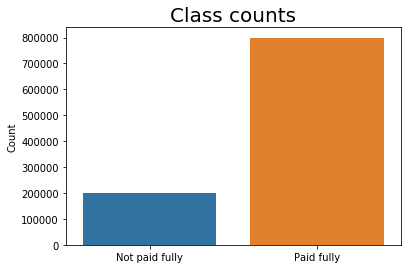

In [4]:
df_loan_status_1=df[df["loan_status"]==1]
df_loan_status_0=df[df["loan_status"]==0]
sns.countplot(df["loan_status"])
plt.xticks((0, 1), [ "Not paid fully","Paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20})

In [5]:
df2=df[["annual_inc","emp_title"]]
#df2["emp_title"] = [str(row).lower().strip(" ").strip(",").strip("?").strip('!').strip('\t').strip("\"a\"").strip("&").strip('å').strip('{').strip('}').strip("|").strip("")  for row in df2["emp_title"]]
df2["emp_title"].value_counts()[0:20]



Teacher               15774
Manager               14361
Owner                  7443
Registered Nurse       6570
RN                     6344
Supervisor             6192
Driver                 5528
Sales                  5491
Project Manager        4701
Office Manager         4128
General Manager        3853
Director               3762
manager                3380
owner                  3322
Engineer               3144
teacher                3074
President              3063
driver                 2621
Vice President         2587
Operations Manager     2530
Name: emp_title, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text xticklabel objects>)

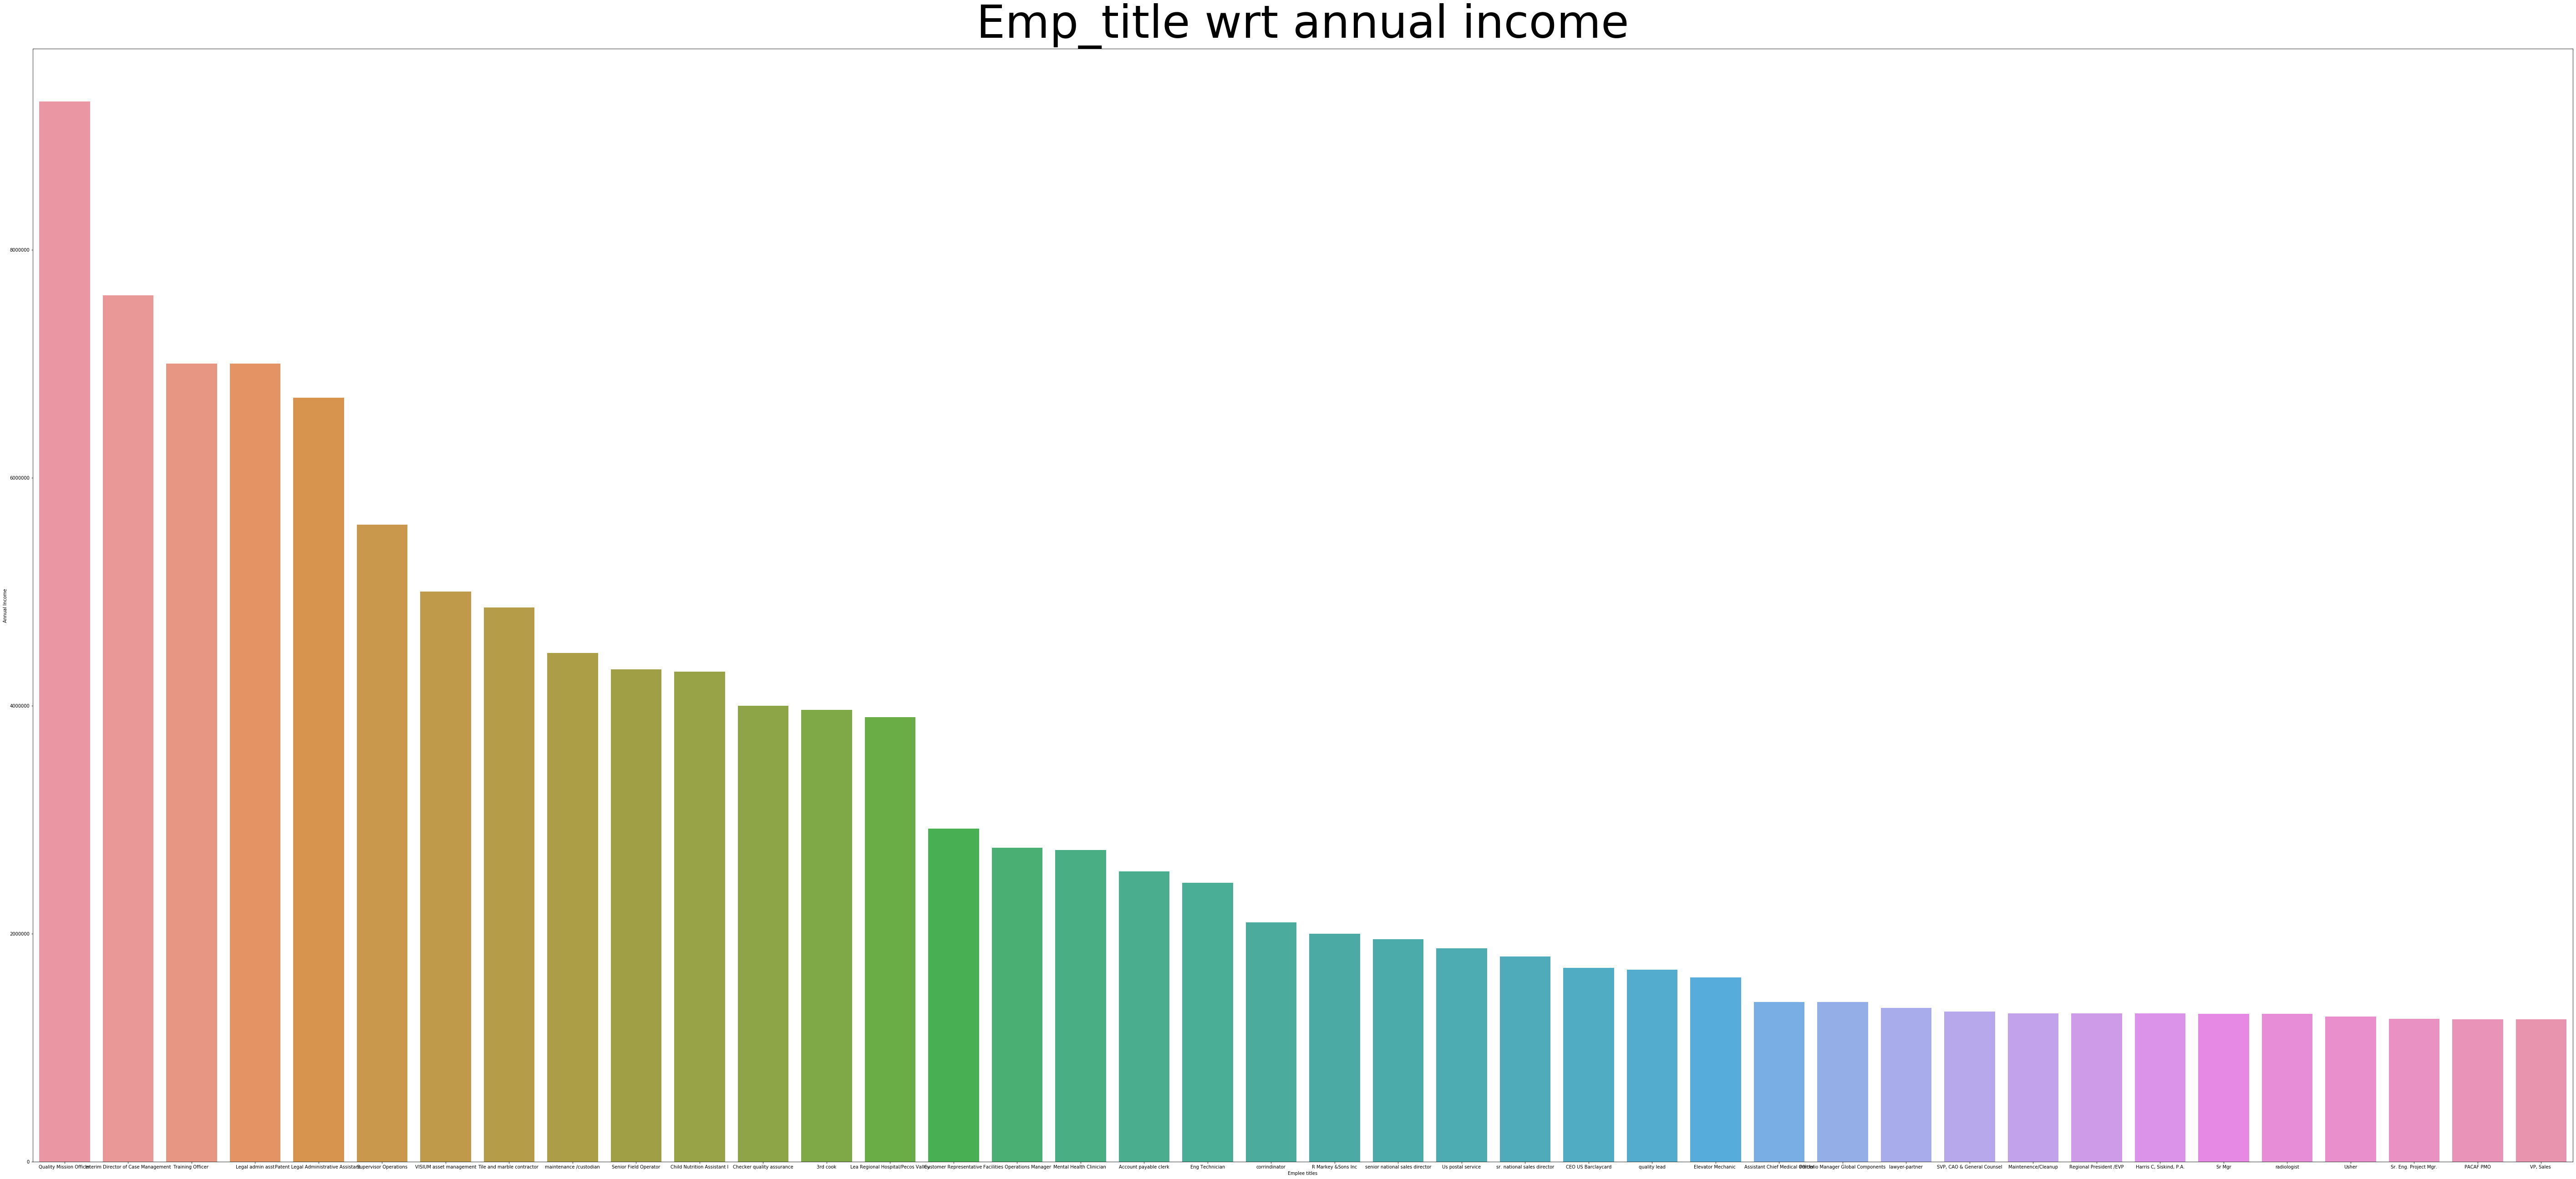

In [6]:
df2 = df[["annual_inc","emp_title"]]
df2 = df2.groupby(["emp_title"]).mean()
df2 = df2.sort_values(by="annual_inc",ascending = False)
# visualize job titles and annual income
plt.figure(figsize = (100,45))
sns.barplot(x = df2.iloc[:40].index, y = df2.iloc[0:40]["annual_inc"])
plt.title("Emp_title wrt annual income",fontsize=100)
plt.xlabel("Emplee titles")
plt.ylabel("Annual Income")
plt.xticks(size = 10)


- So, we decided to keep emp_title column in the model and merge some mostly observed similar titles as shown below.

In [7]:
df['emp_title']= df['emp_title'].replace(np.nan, 'unknown', regex=True)
df['emp_title']= df['emp_title'].str.lower()

df.loc[df.emp_title.str.contains('manager') , 'emp_title'] = 'manager'
df.loc[df.emp_title.str.contains('unknown') , 'emp_title'] = 'unknown'
df.loc[df.emp_title.str.contains('teacher') , 'emp_title'] = 'teacher'
df.loc[df.emp_title.str.contains('owner') , 'emp_title'] = 'owner'
df.loc[df.emp_title.str.contains('registered nurse') , 'emp_title'] = 'registered nurse'
df.loc[df['emp_title']=='rn' , 'emp_title'] = 'registered nurse'
df.loc[df.emp_title.str.contains('president') , 'emp_title']='president'


In [8]:
#drop categorical features hard to deal
df.drop(["zip_code"],axis =1 ,inplace = True)

#emp_length should be a numerical column, so make it numeric and fill NaN's with 0
df["emp_length2"] = [ each.replace("years","year").replace("<",'').strip().split("year")[0] if each != 'NaN' and type(each) == str else each for each in df["emp_length"]]  #10+ ve NaNlar duruyor ayrıca hala string
df["emp_length2"] = [int(int(each.replace('+',''))*1.3)   if '+' in str(each)  else  each for each in df["emp_length2"]]
df.drop(["emp_length"],axis = 1 ,inplace=True)
df.rename(columns={"emp_length2": "emp_length"},inplace=True )
df['emp_length'].fillna(value =0,inplace=True) #fill NaN's with 0 (otherwise cant  use astype)
df = df.astype({"emp_length": int} )


#emp_length : to numerical (no new column added)
df["earliest_cr_line2"] = [each.split('-')[1] for each in df["earliest_cr_line"]]
df.drop(["earliest_cr_line"],axis =1,inplace = True)
df.earliest_cr_line2=df.earliest_cr_line2.astype(int)
df["earliest_cr_line2"] = df["earliest_cr_line2"].apply(lambda x:int(2019-x))
df.rename(columns={'earliest_cr_line2': 'earliest_cr_line_duration'}, inplace=True)


categorical_features=list (df.select_dtypes(include=['category','object']).columns)
numerical_features=list (set (df.columns)-set(categorical_features))

# replace missing numerical values with 0
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='constant') #means fill with 0 
df[numerical_features] = imputer.fit_transform(df[numerical_features])


#encoding categorical variables

from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

# labelEncodings : 0,1,2,.... (n-1) ,(no new column added)
df["verification_status"] = lb_make.fit_transform(df["verification_status"])
df["purpose"] = lb_make.fit_transform(df["purpose"])
df['addr_state']=lb_make.fit_transform(df['addr_state'])
df['emp_title']=lb_make.fit_transform(df['emp_title'])



# binaryEncodings : 0-1 yes no, (no new column added)
df.term= df.term.eq(' 60 months').mul(1) # assign 0 if ' 36 months'
df.application_type=df.application_type.eq('Joint App').mul(1) #0 if 'Individual'

# One Hot Encoding: 13 new column added, -2 removed
df=pd.get_dummies(df,columns=['grade', 'home_ownership'])

# instead of one-hot encoding, one can also try labelencoding to reduce dimensionality
#df['grade']=lb_make.fit_transform(df['grade'])
#df['home_ownership']=lb_make.fit_transform(df['home_ownership'])

df.drop(df[df["annual_inc"] <1000].index,inplace=True) #FAKIRLERI DROPLAYALIM BENCE
df.drop(df[df["annual_inc"] >1000000].index,inplace=True)#ZENGINLERI DROPLAYALIM BENCE

In [9]:
# RobustScaler is robust to outliers.
from sklearn.preprocessing import RobustScaler
df['annual_inc'] = RobustScaler().fit_transform(df['annual_inc'].values.reshape(-1,1))
df['term'] = RobustScaler().fit_transform(df['term'].values.reshape(-1,1))
#df['verification_status'] = RobustScaler().fit_transform(df['verification_status'].values.reshape(-1,1))

df['delinq_2yrs'] = RobustScaler().fit_transform(df['delinq_2yrs'].values.reshape(-1,1))
df['inq_last_6mths'] = RobustScaler().fit_transform(df['inq_last_6mths'].values.reshape(-1,1))

df['pub_rec'] = RobustScaler().fit_transform(df['pub_rec'].values.reshape(-1,1))
df['revol_bal'] = RobustScaler().fit_transform(df['revol_bal'].values.reshape(-1,1))

df['revol_util'] = RobustScaler().fit_transform(df['revol_util'].values.reshape(-1,1))
df['collections_12_mths_ex_med'] = RobustScaler().fit_transform(df['collections_12_mths_ex_med'].values.reshape(-1,1))
df['tot_coll_amt'] = RobustScaler().fit_transform(df['tot_coll_amt'].values.reshape(-1,1))
df['tot_cur_bal'] = RobustScaler().fit_transform(df['tot_cur_bal'].values.reshape(-1,1))

df['pub_rec'] = RobustScaler().fit_transform(df['pub_rec'].values.reshape(-1,1))
df['revol_bal'] = RobustScaler().fit_transform(df['revol_bal'].values.reshape(-1,1))


#df['earliest_cr_line'] = RobustScaler().fit_transform(df['earliest_cr_line'].values.reshape(-1,1))
df['loan_amnt'] = RobustScaler().fit_transform(df['loan_amnt'].values.reshape(-1,1))
#df['addr_state'] = RobustScaler().fit_transform(df['addr_state'].values.reshape(-1,1))
df['dti'] = RobustScaler().fit_transform(df['dti'].values.reshape(-1,1))
df['emp_length'] = RobustScaler().fit_transform(df['emp_length'].values.reshape(-1,1))
#df['purpose'] = RobustScaler().fit_transform(df['purpose'].values.reshape(-1,1))
df['open_acc'] = RobustScaler().fit_transform(df['open_acc'].values.reshape(-1,1))

#df.drop(['annual_inc','Amount'], axis=1, inplace=True)
#df.drop(['annual_inc'], axis=1, inplace=True)


**Imputed and Scaled Dataset:**

In [10]:
df.head(5)

,loan_amnt,term,emp_title,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,...,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,0.104167,1.0,83040,-0.294118,1,2,10,-0.179739,0.0,3.0,...,0,1,0,0,0,0,0,0,1,0
1,1.916667,0.0,52124,2.488688,2,1,5,0.200163,3.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,0.000000,0.0,209499,0.678733,0,2,14,-0.057190,3.0,1.0,...,0,0,0,0,0,1,0,0,0,0
3,-0.010417,0.0,194162,-0.339367,2,2,34,1.137255,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,2.125000,0.0,126422,0.226244,1,0,3,-0.132353,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


**Oversampling the minority class by SMOTE method for training dataset**


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1),df['loan_status'] , test_size=0.25,random_state=43)

from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=7)

oversampled_trainX, oversampled_trainY = sm.fit_sample(X_train,y_train )
#oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)



Using TensorFlow backend.


# Model 1 : Random Forest Classifer (Without Oversampling)

**Since we have 69 columns are Random Forest is robust to overfitting, we choose max_depth as 50 after trying smaller values greedily.**

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


model_rf2 = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=50,
    min_samples_split=2,min_samples_leaf=4,min_weight_fraction_leaf=0.0, max_features='auto',
    max_leaf_nodes=None, min_impurity_decrease=0.0,min_impurity_split=None,
    bootstrap=True, oob_score=False, n_jobs=-1, random_state=0,
    verbose=0, warm_start=False,class_weight='balanced')

model_rf2.fit(X_train, y_train)
rf_predictions = model_rf2.predict(X_test)


In [22]:
from sklearn.metrics import fbeta_score,confusion_matrix,classification_report
rf_acc = accuracy_score(y_test, rf_predictions)
print("For Max Depth ",model_rf2.max_depth)
print("Random Forest Accuracy:"+str(rf_acc))
print("Macro F1 Score :",f1_score(y_test, rf_predictions, average='macro'))
print("Macro F1 Beta Score :",fbeta_score(y_test, rf_predictions, average='macro', beta=0.5))
print("Micro F1 Score :",fbeta_score(y_test, rf_predictions, average='micro', beta=0.5))
print("Weighted F1 Score :",fbeta_score(y_test, rf_predictions, average='weighted', beta=0.5))
print("Confusion Matrix : \n", confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions, digits=5))

For Max Depth  50
Random Forest Accuracy:0.7937411209156212
Macro F1 Score : 0.5858463700142919
Macro F1 Beta Score : 0.6120891345821979
Micro F1 Score : 0.7937411209156212
Weighted F1 Score : 0.7526521543801533
Confusion Matrix : 
 [[ 10650  39445]
 [ 12096 187694]]
              precision    recall  f1-score   support

         0.0    0.46821   0.21260   0.29242     50095
         1.0    0.82634   0.93946   0.87928    199790

    accuracy                        0.79374    249885
   macro avg    0.64728   0.57603   0.58585    249885
weighted avg    0.75455   0.79374   0.76163    249885



# Model 2: Random Forest with Oversampling

In [23]:
model_rf_o = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=50,
    min_samples_split=2,min_samples_leaf=4,min_weight_fraction_leaf=0.0, max_features='auto',
    max_leaf_nodes=None, min_impurity_decrease=0.0,min_impurity_split=None,
    bootstrap=True, oob_score=False, n_jobs=-1, random_state=0,
    verbose=0, warm_start=False,class_weight='balanced')

model_rf_o.fit(oversampled_trainX, oversampled_trainY)
rf_predictions_o = model_rf_o.predict(X_test)


In [24]:
from sklearn.metrics import fbeta_score,confusion_matrix,classification_report
rf_acc_o = accuracy_score(y_test, rf_predictions_o)
print("For Max Depth ",model_rf_o.max_depth)
print("Random Forest Accuracy:"+str(rf_acc))
print("Macro F1 Score :",f1_score(y_test, rf_predictions_o, average='macro'))
print("Macro F1 Beta Score :",fbeta_score(y_test, rf_predictions_o, average='macro', beta=0.5))
print("Micro F1 Score :",fbeta_score(y_test, rf_predictions_o, average='micro', beta=0.5))
print("Weighted F1 Score :",fbeta_score(y_test, rf_predictions_o, average='weighted', beta=0.5))
print("Confusion Matrix : \n", confusion_matrix(y_test, rf_predictions_o))
print(classification_report(y_test, rf_predictions_o, digits=5))

For Max Depth  50
Random Forest Accuracy:0.7937411209156212
Macro F1 Score : 0.5338082856671107
Macro F1 Beta Score : 0.5698092004948403
Micro F1 Score : 0.8018128339035957
Weighted F1 Score : 0.7326098956863709
Confusion Matrix : 
 [[  5448  44647]
 [  4877 194913]]
              precision    recall  f1-score   support

         0.0    0.52765   0.10875   0.18034     50095
         1.0    0.81363   0.97559   0.88728    199790

    accuracy                        0.80181    249885
   macro avg    0.67064   0.54217   0.53381    249885
weighted avg    0.75630   0.80181   0.74556    249885



**It is seen that oversampling the dataset results in lower recall values for 0.0 label but higher recall values for 1.0(will pay) label.**

**In Kaggle Competition, although the models have similar scores, we used oversampled Random Forest because it yield slightly higher in the leaderboard.**

**Printing feature importance list of our Random Forest Model (in descending order)**

In [33]:
# Get importance list from model
feature_list=list(set (df.columns)-set('loan_status'))

# Create list of tuples by combining(zip) feature list and and importance list 
feature_importance= list(model_rf_o.feature_importances_)
feature_importance=[(feature,round(importance,5)) for feature, importance in zip(feature_list,feature_importance)]
# Sort features by importance

feature_importance= sorted(feature_importance,key=lambda x:x[1],reverse=True)
feature_importance

[('dti', 0.10599),
 ('collections_12_mths_ex_med', 0.06882),
 ('num_sats', 0.06517),
 ('num_rev_tl_bal_gt_0', 0.05714),
 ('percent_bc_gt_75', 0.03826),
 ('home_ownership_OWN', 0.03648),
 ('avg_cur_bal', 0.03449),
 ('total_il_high_credit_limit', 0.02936),
 ('home_ownership_OTHER', 0.02612),
 ('num_rev_accts', 0.02271),
 ('home_ownership_RENT', 0.01946),
 ('earliest_cr_line_duration', 0.01925),
 ('tot_cur_bal', 0.01912),
 ('loan_amnt', 0.01904),
 ('grade_E', 0.01807),
 ('home_ownership_NONE', 0.01668),
 ('home_ownership_ANY', 0.01547),
 ('grade_A', 0.01491),
 ('delinq_2yrs', 0.01411),
 ('mo_sin_old_rev_tl_op', 0.01376),
 ('num_tl_op_past_12m', 0.01356),
 ('emp_title', 0.01314),
 ('num_il_tl', 0.01289),
 ('mort_acc', 0.01275),
 ('inq_last_6mths', 0.01229),
 ('open_acc', 0.01224),
 ('mths_since_recent_bc', 0.01223),
 ('addr_state', 0.01214),
 ('pub_rec', 0.01186),
 ('verification_status', 0.01137),
 ('grade_F', 0.01129),
 ('bc_open_to_buy', 0.01124),
 ('delinq_amnt', 0.01114),
 ('term', 0.

# Model 2 : XGBoost (without Grid Search)

Aggregating weak learners to compensate the errors of previos ones can be helpful.
To deal with class imbalace, we set scale_pos_weight to 1/4 ( the label ratio )

In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(max_depth=6,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=100,
                        learning_rate = 0.05,
                        scale_pos_weight =0.25)
# fit the model with the training data
model_xgb.fit(oversampled_trainX,oversampled_trainY)

xgb_predictions = model_xgb.predict(X_test)


In [31]:
from sklearn.metrics import fbeta_score,confusion_matrix,accuracy_score,f1_score,classification_report
xgb_acc = accuracy_score(y_test, xgb_predictions)
print("XGB Accuracy:"+str(xgb_acc))
print("Macro F1 Score :",f1_score(y_test, xgb_predictions, average='macro'))
print("Macro F1 Beta Score :",fbeta_score(y_test, xgb_predictions, average='macro', beta=0.5))
print("Micro F1 Score :",fbeta_score(y_test, xgb_predictions, average='micro', beta=0.5))
print("Weighted F1 Score :",fbeta_score(y_test, xgb_predictions, average='weighted', beta=0.5))
print("Confusion Matrix : \n", confusion_matrix(y_test, xgb_predictions))
print(classification_report(y_test, xgb_predictions, digits=5))

XGB Accuracy:0.596558416871761
Macro F1 Score : 0.5578309042887404
Macro F1 Beta Score : 0.5702169878208367
Micro F1 Score : 0.596558416871761
Weighted F1 Score : 0.7085363327642596
Confusion Matrix : 
 [[ 37559  12536]
 [ 88278 111512]]
              precision    recall  f1-score   support

         0.0    0.29847   0.74976   0.42697     50095
         1.0    0.89894   0.55815   0.68869    199790

    accuracy                        0.59656    249885
   macro avg    0.59871   0.65395   0.55783    249885
weighted avg    0.77857   0.59656   0.63622    249885



- **Applying The Same Preprocessing to The Test Data**
- **Outputs the predictions as a CSV file**

In [34]:


df_sub = pd.read_csv('loansTest.csv')
df_sub['emp_title']= df_sub['emp_title'].replace(np.nan, 'unknown', regex=True)
df_sub['emp_title']= df_sub['emp_title'].str.lower()

df_sub.loc[df_sub.emp_title.str.contains('manager') , 'emp_title'] = 'manager'
df_sub.loc[df_sub.emp_title.str.contains('unknown') , 'emp_title'] = 'unknown'
df_sub.loc[df_sub.emp_title.str.contains('teacher') , 'emp_title'] = 'teacher'
df_sub.loc[df_sub.emp_title.str.contains('owner') , 'emp_title'] = 'owner'
df_sub.loc[df_sub.emp_title.str.contains('registered nurse') , 'emp_title'] = 'registered nurse'
df_sub.loc[df_sub['emp_title']=='rn' , 'emp_title'] = 'registered nurse'
df_sub.loc[df_sub.emp_title.str.contains('president') , 'emp_title']='president'


#drop categorical features hard to deal  #no "emp_title"
df_sub.drop(["zip_code"],axis =1 ,inplace = True)

#emp_length should be a numerical column, so make it numeric and fill NaN's with 0
df_sub["emp_length2"] = [ each.replace("years","year").replace("<",'').strip().split("year")[0] if each != 'NaN' and type(each) == str else each for each in df_sub["emp_length"]]  #10+ ve NaNlar duruyor ayrıca hala string
df_sub["emp_length2"] = [int(int(each.replace('+',''))*1.3)   if '+' in str(each)  else  each for each in df_sub["emp_length2"]]
df_sub.drop(["emp_length"],axis = 1 ,inplace=True)
df_sub.rename(columns={"emp_length2": "emp_length"},inplace=True )
df_sub['emp_length'].fillna(value =0,inplace=True) #fill NaN's with 0 (otherwise cant  use astype)
df_sub = df_sub.astype({"emp_length": int} )

#Bence earliest_cr_line'ı kullanalım, ama duration olarak

#emp_length : to numerical (no new column added)
df_sub["earliest_cr_line2"] = [each.split('-')[1] for each in df_sub["earliest_cr_line"]]
df_sub.drop(["earliest_cr_line"],axis =1,inplace = True)
df_sub.earliest_cr_line2=df_sub.earliest_cr_line2.astype(int)
df_sub["earliest_cr_line2"] = df_sub["earliest_cr_line2"].apply(lambda x:int(2019-x))
df_sub.rename(columns={'earliest_cr_line2': 'earliest_cr_line_duration'}, inplace=True)


categorical_features=list (df_sub.select_dtypes(include=['category','object']).columns)
numerical_features=list (set (df_sub.columns)-set(categorical_features))

# replace missing numerical values with 0
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='constant') #means fill with 0 
df_sub[numerical_features] = imputer.fit_transform(df_sub[numerical_features])


#encoding categorical variables

from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

# labelEncodings : 0,1,2,.... (n-1) ,(no new column added)
df_sub["verification_status"] = lb_make.fit_transform(df_sub["verification_status"])
df_sub["purpose"] = lb_make.fit_transform(df_sub["purpose"])
df_sub['addr_state']=lb_make.fit_transform(df_sub['addr_state'])
df_sub['emp_title']=lb_make.fit_transform(df_sub['emp_title'])

# binaryEncodings : 0-1 yes no, (no new column added)
df_sub.term= df_sub.term.eq(' 60 months').mul(1) # assign 0 if ' 36 months'
df_sub.application_type=df_sub.application_type.eq('Joint App').mul(1) #0 if 'Individual'

# One Hot Encoding: 13 new column added, -2 removed
df_sub=pd.get_dummies(df_sub,columns=['grade', 'home_ownership'])

#BERK update : instead of one-hot now trying with labelencoding to reduce dimensionality
#df_sub['grade']=lb_make.fit_transform(df_sub['grade'])
#df_sub['home_ownership']=lb_make.fit_transform(df_sub['home_ownership'])


# RobustScaler is robust to outliers.
from sklearn.preprocessing import RobustScaler
df_sub['annual_inc'] = RobustScaler().fit_transform(df_sub['annual_inc'].values.reshape(-1,1))
df_sub['term'] = RobustScaler().fit_transform(df_sub['term'].values.reshape(-1,1))
#df['verification_status'] = RobustScaler().fit_transform(df['verification_status'].values.reshape(-1,1))

df_sub['delinq_2yrs'] = RobustScaler().fit_transform(df_sub['delinq_2yrs'].values.reshape(-1,1))
df_sub['inq_last_6mths'] = RobustScaler().fit_transform(df_sub['inq_last_6mths'].values.reshape(-1,1))

df_sub['pub_rec'] = RobustScaler().fit_transform(df_sub['pub_rec'].values.reshape(-1,1))
df_sub['revol_bal'] = RobustScaler().fit_transform(df_sub['revol_bal'].values.reshape(-1,1))

df_sub['revol_util'] = RobustScaler().fit_transform(df_sub['revol_util'].values.reshape(-1,1))
df_sub['collections_12_mths_ex_med'] = RobustScaler().fit_transform(df_sub['collections_12_mths_ex_med'].values.reshape(-1,1))
df_sub['tot_coll_amt'] = RobustScaler().fit_transform(df_sub['tot_coll_amt'].values.reshape(-1,1))
df_sub['tot_cur_bal'] = RobustScaler().fit_transform(df_sub['tot_cur_bal'].values.reshape(-1,1))

df_sub['pub_rec'] = RobustScaler().fit_transform(df_sub['pub_rec'].values.reshape(-1,1))
df_sub['revol_bal'] = RobustScaler().fit_transform(df_sub['revol_bal'].values.reshape(-1,1))


#df['earliest_cr_line'] = RobustScaler().fit_transform(df['earliest_cr_line'].values.reshape(-1,1))
df_sub['loan_amnt'] = RobustScaler().fit_transform(df_sub['loan_amnt'].values.reshape(-1,1))
#df['addr_state'] = RobustScaler().fit_transform(df['addr_state'].values.reshape(-1,1))
df_sub['dti'] = RobustScaler().fit_transform(df_sub['dti'].values.reshape(-1,1))
df_sub['emp_length'] = RobustScaler().fit_transform(df_sub['emp_length'].values.reshape(-1,1))
#df['purpose'] = RobustScaler().fit_transform(df['purpose'].values.reshape(-1,1))
df_sub['open_acc'] = RobustScaler().fit_transform(df_sub['open_acc'].values.reshape(-1,1))

df_sub.drop(['ID'],axis=1,inplace = True)
df_sub.head()

predictions_submission = model_rf_o.predict(df_sub)
res = pd.DataFrame(predictions_submission,columns=["loan_status"])
res["ID"] = np.arange(303605)

# Place the class in the begining of the dataframe

Class = res['ID']
res.drop(['ID'], axis=1, inplace=True)
res.insert(0, 'ID', Class)

res["loan_status"] =res.loan_status.astype('int')
res.to_csv('submission_berk_rf.csv',index=False)

